In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator

creator.create("obj", base.Fitness, weights=(-1.0,-1.0, -1.0))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.05, 'max': 0.07},
  'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../../moltres/python/moltres_xs.py',
     'fhr_assem_gc.inp']],
   'inputs': ['total_pf',
    'sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['total_pf', 'ppf', 'keff']},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 64 -N 64 -d 1 -j 1 mol

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=22)
    ax.set_ylabel(obj_name, fontsize=22)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

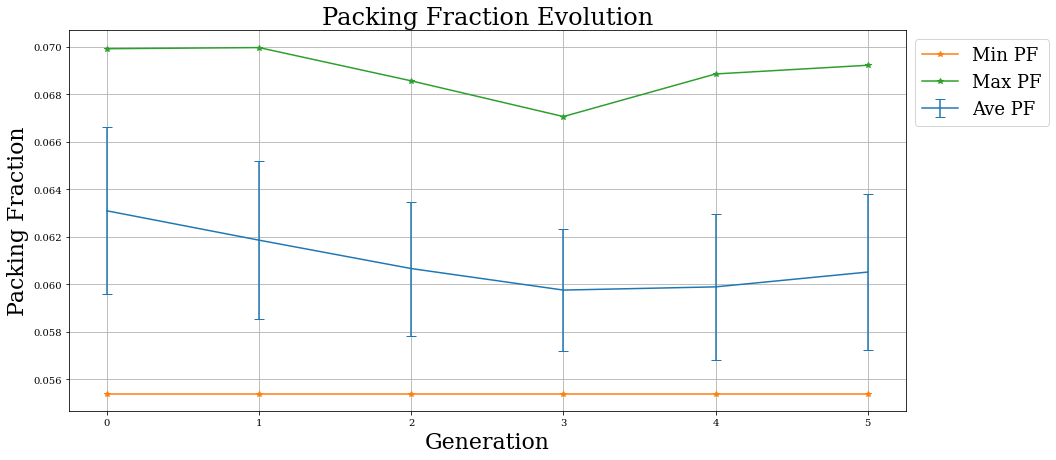

In [7]:
plot_1_obj(logbook, 0, "Packing Fraction", "PF", False, "assem-obj-2-pf-evol.png")

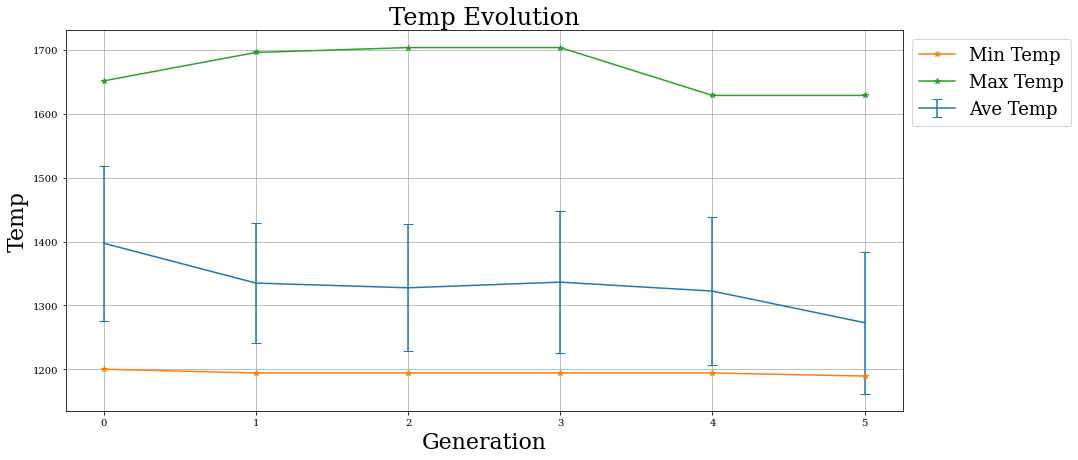

In [8]:
plot_1_obj(logbook, 1, "Temp", "Temp", False, "assem-obj-2-pf-evol.png")

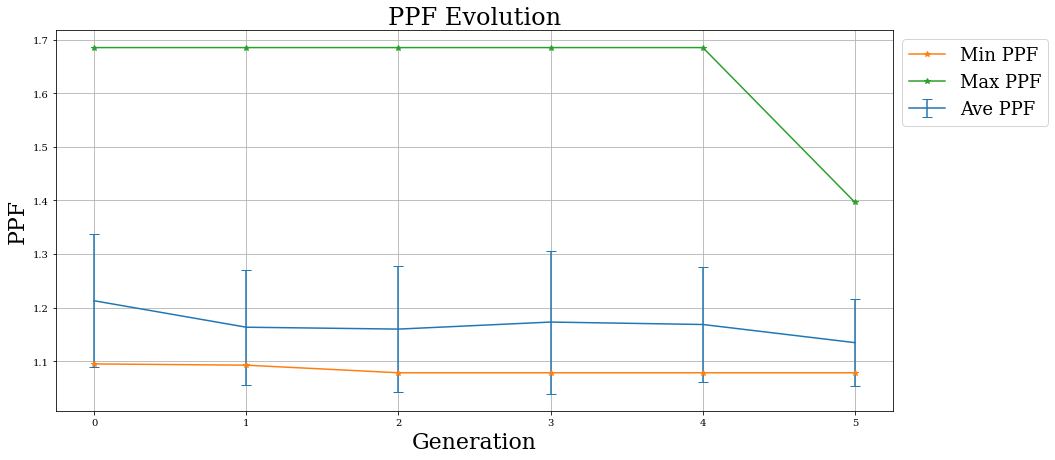

In [9]:
plot_1_obj(logbook, 2, "PPF", "PPF", False, "assem-obj-2-pf-evol.png")

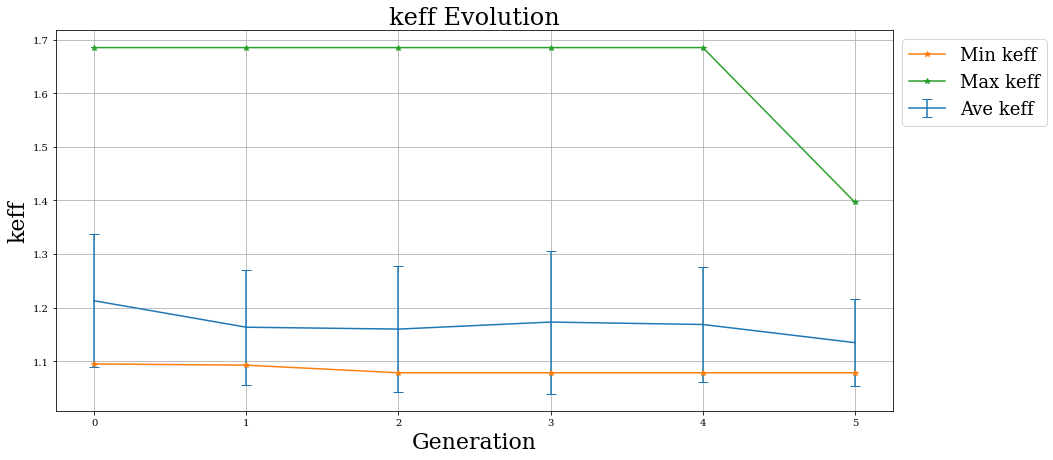

In [10]:
plot_1_obj(logbook, 2, "keff", "keff", False, "")

In [11]:
results = cp["all"]
ref = np.array([0.07, 1700 ,1.8])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

4.092585898242558
4.223365128939307
4.400217721424151
4.425023097024399
4.5312435367862856
4.5681421351548455


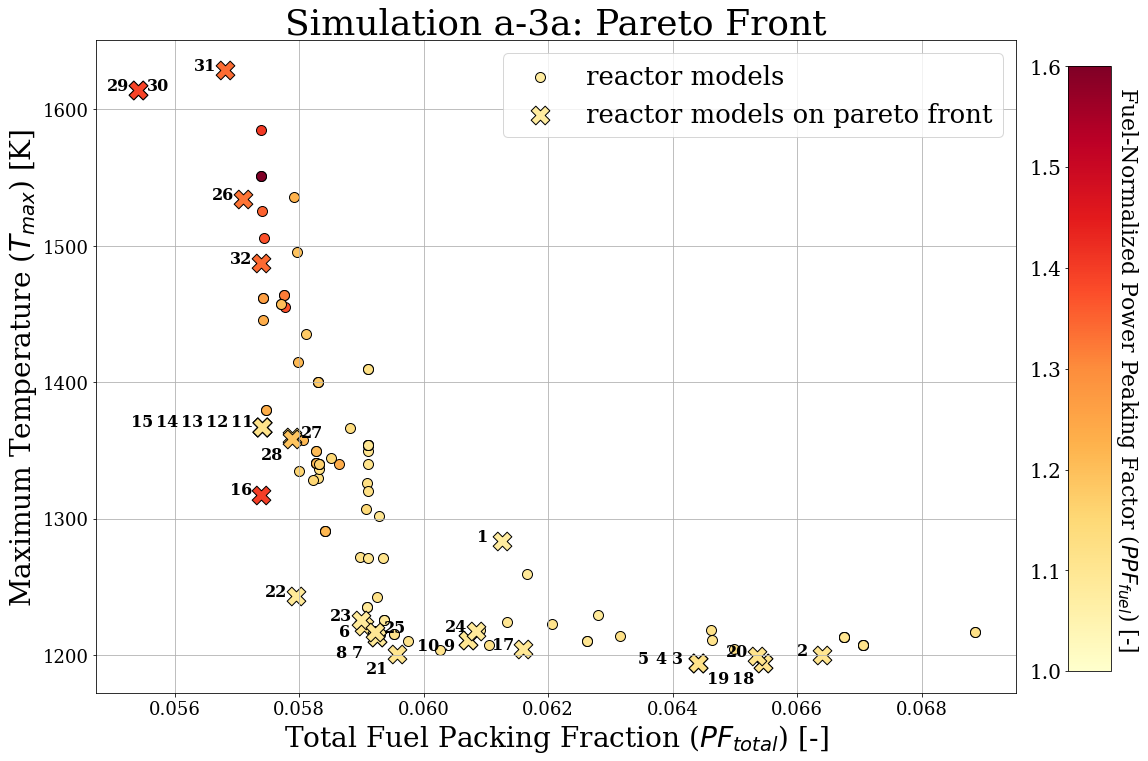

In [12]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][4]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(12, 12))
count1, count2 = 0, 0
for i, ind in enumerate(pop):
    if count1 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, vmax=1.6, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=100, label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, vmax=1.6, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=100)
prev_0, prev_1 = 0, 0
num = 1
for i, ind in enumerate(final_non_dom):
    if count2 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                   vmax=1.6, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1, 
                   label="reactor models on pareto front")
        count2 += 1
    else:
        im = ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                    vmax=1.6, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 17
            else:
                offset_x -= 25
        else:
            offset_x = -20
        if i in [6,7,17,18,20,27]:
            offset_y = -20
        if i in [5, 8, 9]:
            offset_y = -10
        if i in [9]:
            offset_x = -40
        if i in [24,26,29]:
            offset_x = 20
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=26, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.25, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cbar_ax.yaxis.set_ticks_position('left')
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=28)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=28)
cb.set_label(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]', fontsize=22, rotation=270, labelpad=30)
ax.set_title('Simulation a-3a: Pareto Front',fontsize=36)
plt.savefig("assem-obj-3-2d.png",bbox_inches='tight', dpi=300)


In [13]:
total_pf, total_temp, total_ppf = 0, 0, 0
for ind in final_non_dom:
    total_pf += ind.output[0]
    total_temp += ind.output[1]
    total_ppf += ind.output[2]
print(total_pf/len(final_non_dom), total_temp/len(final_non_dom),total_ppf/len(final_non_dom))

0.0598932986906881 1305.7933319352783 1.1551180046281844


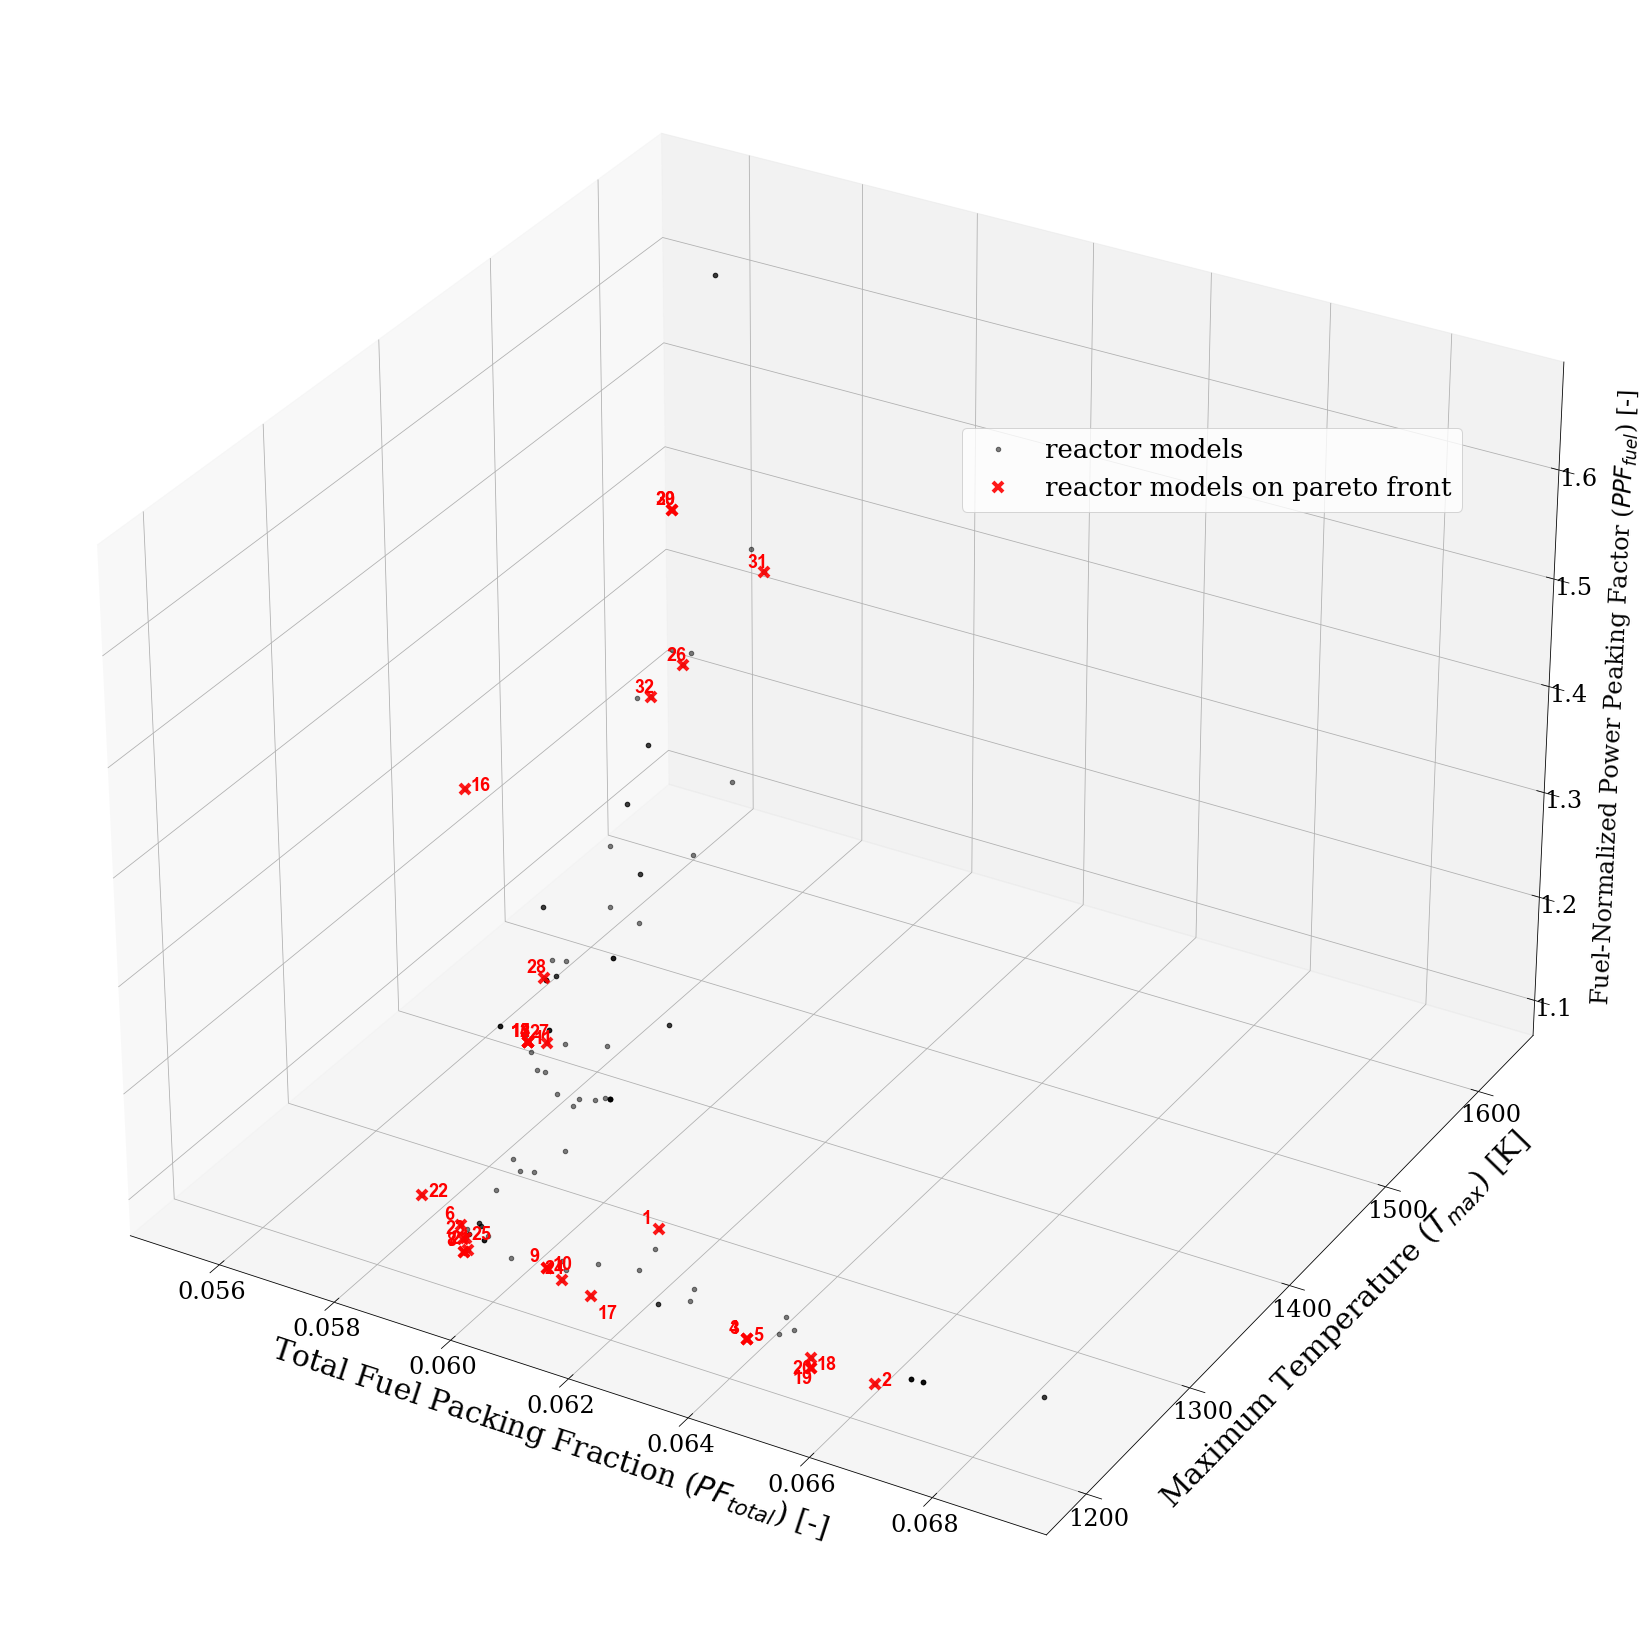

In [14]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][4]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')
for i, ind in enumerate(pop):
    if i == 0:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=9, alpha=0.5, label="reactor models")
    else:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=9, alpha=0.5)
count = 1
prev_x_pos = 0
for i, ind in enumerate(final_non_dom[:]):
    if i == 0:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.9, ms=10, mew=4, color="red",label="reactor models on pareto front")
    else:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.9, ms=10, mew=4, color="red")
    x_mov = -0.0003
    y_mov = 0
    z_mov = 0
    if i in [4,9,10,1,15,17,21,24]:
        x_mov += 0.0004
        #z_mov += 0.01
    if i in [16]:
        x_mov += 0.0004
        z_mov -= 0.02
    if i in [18,19]:
        z_mov -= 0.02
    x_pos = ind.fitness.values[0]+x_mov
    y_pos = ind.fitness.values[1]+y_mov
    z_pos = ind.fitness.values[2]+z_mov
    #print(i, x_mov, y_mov, z_mov)
    ax.text(x_pos, y_pos, z_pos, count, color="red", weight='heavy', size=18, font={'family': 'arial'})
    prev_x_pos = x_pos
    count += 1
#ax.legend()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=30,labelpad=20)
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=30,labelpad=20)
ax.set_zlabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=24,labelpad=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=26, bbox_to_anchor = [0.9, 0.75])
#ax.set_title("Final Generation's Pareto Front",fontsize=40, y=1.02)
#ax.set_xlim(0.02, 0.035)
#ax.set_xticks([0.02, 0.025, 0.03, 0.035])
#ax.set_ylim(1200, 1200)
#ax.set_yticks([1130, 1150, 1170, 1190])
#ax.set_zlim(1.0, 1.4)
#ax.set_zticks([1.0, 1.05, 1.1, 1.15])
#plt.savefig("assem-obj-3-3d.png",bbox_inches='tight')

In [15]:
len(final_non_dom)

32

Text(0.5, 1.0, 'Simulation a-3a: Pareto Front')

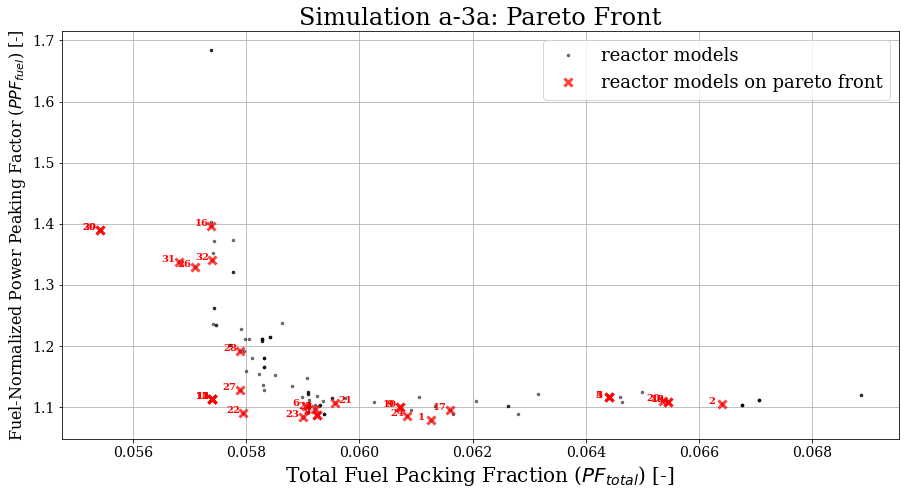

In [16]:
results = cp["all"]
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(15,7.5))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.plot(ind.output[0], ind.output[2], 'k.', ms=5, alpha=0.5, label="reactor models")
        count1 += 1
    else:
        ax.plot(ind.output[0], ind.output[2], 'k.', ms=5, alpha=0.5)
num = 1
prev_0, prev_1 = 0, 0
for ind in final_non_dom:
    if count2 == 0:
        ax.plot(ind.output[0], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3, label="reactor models on pareto front")
        count2 += 1
    else:
        ax.plot(ind.output[0], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[2]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 10
            else:
                offset_x -= 15
        else:
            offset_x = -10
            if num == 21:
                offset_x = 10
        if num in [6,7,8,9,10,22]:
            offset_x = -10
        #print(num, offset_x)
        ax.annotate(str(num), (ind.output[0], ind.output[2]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', color='r', weight='bold') 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
#ax.set_xlim([0.057, 0.061])
#ax.set_ylim(1.05, 1.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_ylabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=16)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=20)
ax.set_title('Simulation a-3a: Pareto Front',fontsize=24)
#plt.savefig("assem-obj-2-pfppf-pareto",bbox_inches='tight')

Text(0.5, 1.0, 'Simulation a-3a: Pareto Front')

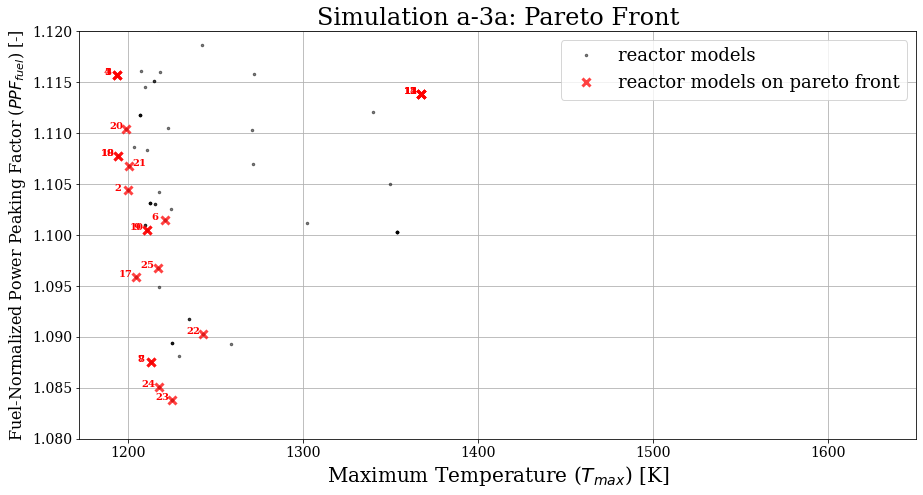

In [17]:
results = cp["all"]
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(15,7.5))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.plot(ind.output[1], ind.output[2], 'k.', ms=5, alpha=0.5, label="reactor models")
        count1 += 1
    else:
        ax.plot(ind.output[1], ind.output[2], 'k.', ms=5, alpha=0.5)
num = 1
prev_0, prev_1 = 0, 0
for ind in final_non_dom:
    if count2 == 0:
        ax.plot(ind.output[1], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3, label="reactor models on pareto front")
        count2 += 1
    else:
        ax.plot(ind.output[1], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[2]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 10
            else:
                offset_x -= 15
        else:
            offset_x = -10
            if num == 21:
                offset_x = 10
        if num in [6,7,8,9,10]:
            offset_x = -10
        #print(num, offset_x)
        ax.annotate(str(num), (ind.output[1], ind.output[2]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', color='r', weight='bold') 
        prev_0, prev_1 = ind.output[1], ind.output[1]
    num += 1
#ax.set_xlim([11, 0.061])
ax.set_ylim(1.08, 1.12)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_ylabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=16)
ax.set_xlabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=20)
ax.set_title('Simulation a-3a: Pareto Front',fontsize=24)
#plt.savefig("assem-obj-2-pfppf-pareto",bbox_inches='tight')

In [18]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
    
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

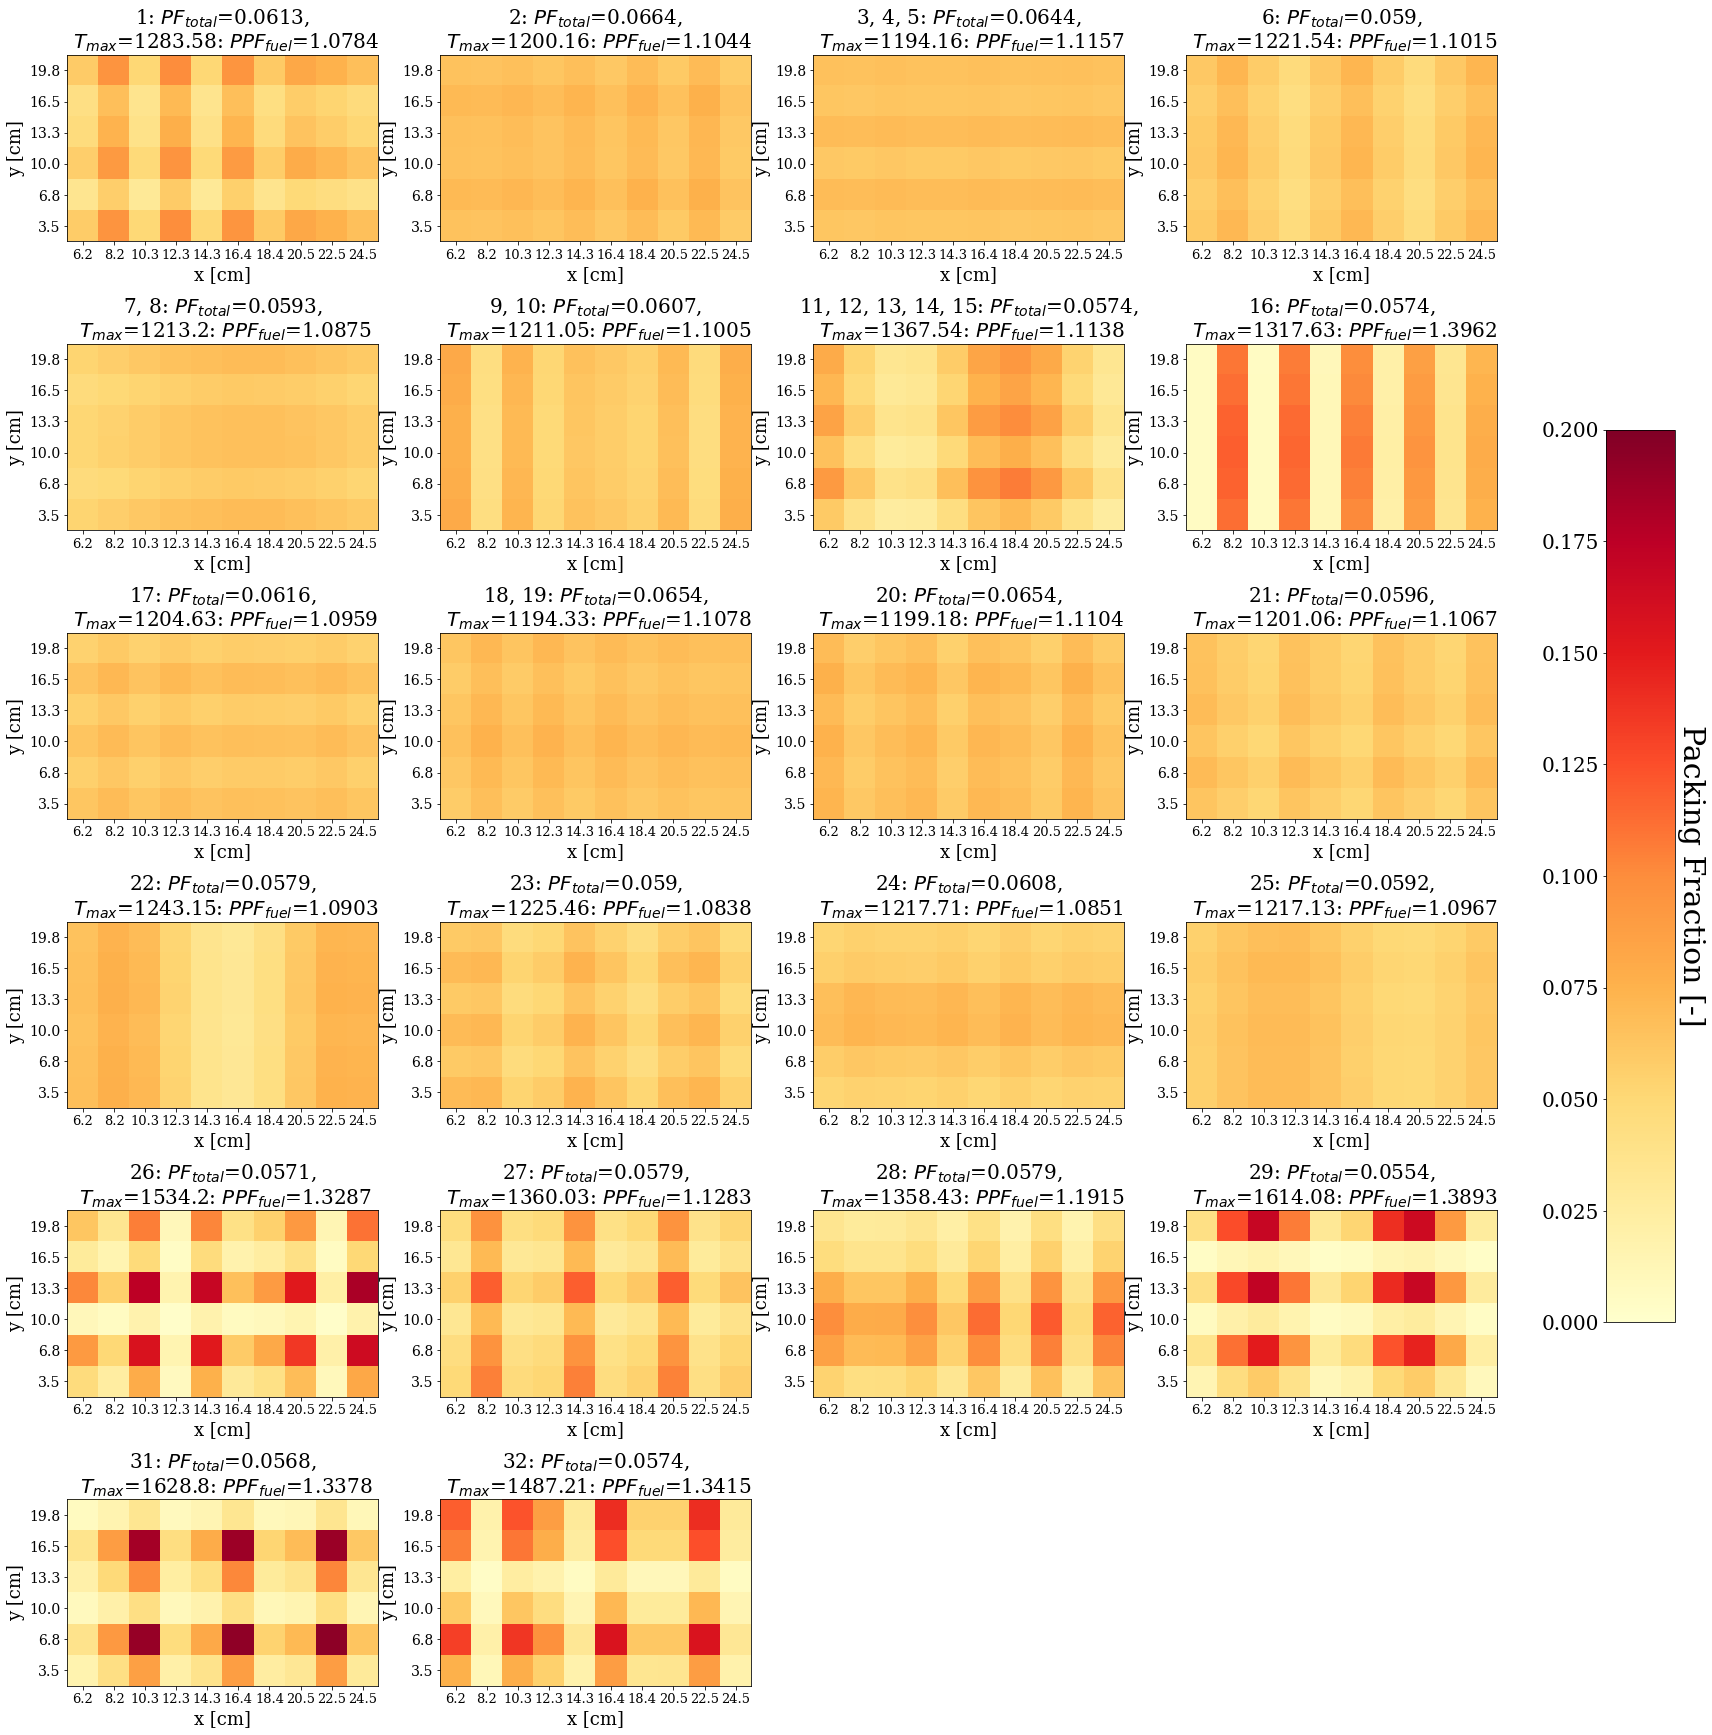

In [19]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, axes = plt.subplots(figsize=(19,31), nrows=6, ncols=4)
count = 0
num = 1
prev_pf, prev_temp, prev_ppf = 0, 0, 0
for i, ind in enumerate(final_non_dom):
    if ind.output[0] != prev_pf and ind.output[1] != prev_temp and ind.output[2] != prev_ppf:
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        #print(pf_distr)
        im = ax.imshow(pf_distr, vmin=0.00, vmax=0.2,cmap="YlOrRd")
        if i+1 == 3:
            nums = "3, 4, 5"
        elif i+1 == 7:
            nums = "7, 8"
        elif i+1 == 9:
            nums = "9, 10"
        elif i+1 == 11:
            nums = "11, 12, 13, 14, 15"
        elif i+1 == 18:
            nums = "18, 19"
        else:
            nums = str(i+1)
        ax.set_title(nums+": $PF_{total}$="+str(round(ind.output[0],4)) + ",\n $T_{max}$="+str(round(ind.output[1],2))
                     +": $PPF_{fuel}$="+str(round(ind.output[2],4)), fontsize=20)
        ax.set_xlabel("x [cm]", fontsize=18)
        ax.set_ylabel("y [cm]", fontsize=18)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=13)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
        num += 1
        prev_pf, prev_temp, prev_ppf = ind.output[0], ind.output[1], ind.output[2]
fig.subplots_adjust(right=1.17)
fig.delaxes(axes[5][2])
fig.delaxes(axes[5][3])
cbar_ax = fig.add_axes([1.25, 0.3, 0.05, 0.4])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cbar_ax.yaxis.set_ticks_position('left')
cb.set_label("Packing Fraction [-]", fontsize=30, rotation=270, labelpad=30)
plt.savefig("assem-obj-3-distr",bbox_inches='tight', dpi=300)


PF, TEMP, PPF 30 3 1
gen, num 3 25
[0.05541072248195178, 1.4837559832090317, 0.6377289505307521, 1.4409677429911905, 1.6509177869472949, 0.8773995796736667, 2.7159048058538735]
29 STD 0.052074978833064285
0.02394019732623519
0.07348326689830446
0.09868513404384292
0.06261707800896123
0.01813022921846347
0.030411916609240308
0.08146557674622883
0.0964814212712131
0.05345648011391766
0.015435924583110624
gen, num 1 55
[0.06440326949397839, 0.02891146873734793, 1.0733154987467008, 2.9635679617428803, 0.13062308868521055, 1.1168642584098638, 6.064636324058878]
2 STD 0.003145275144236632
0.0642947316344941
0.06381256172846715
0.06538341633490295
0.06404676019758067
0.06402356314218664
0.06538707816926266
0.06383151890985857
0.06426912009228511
0.06531799946939428
0.06366594526135166
gen, num 2 60
[0.06126387025877369, 0.6756882981889476, 1.3887531685432808, 3.302176788714785, 0.5327293180408771, 1.1624841034567832, 3.2707445358683476]
0 STD 0.018983389904903673
0.0492169602916163
0.07974719

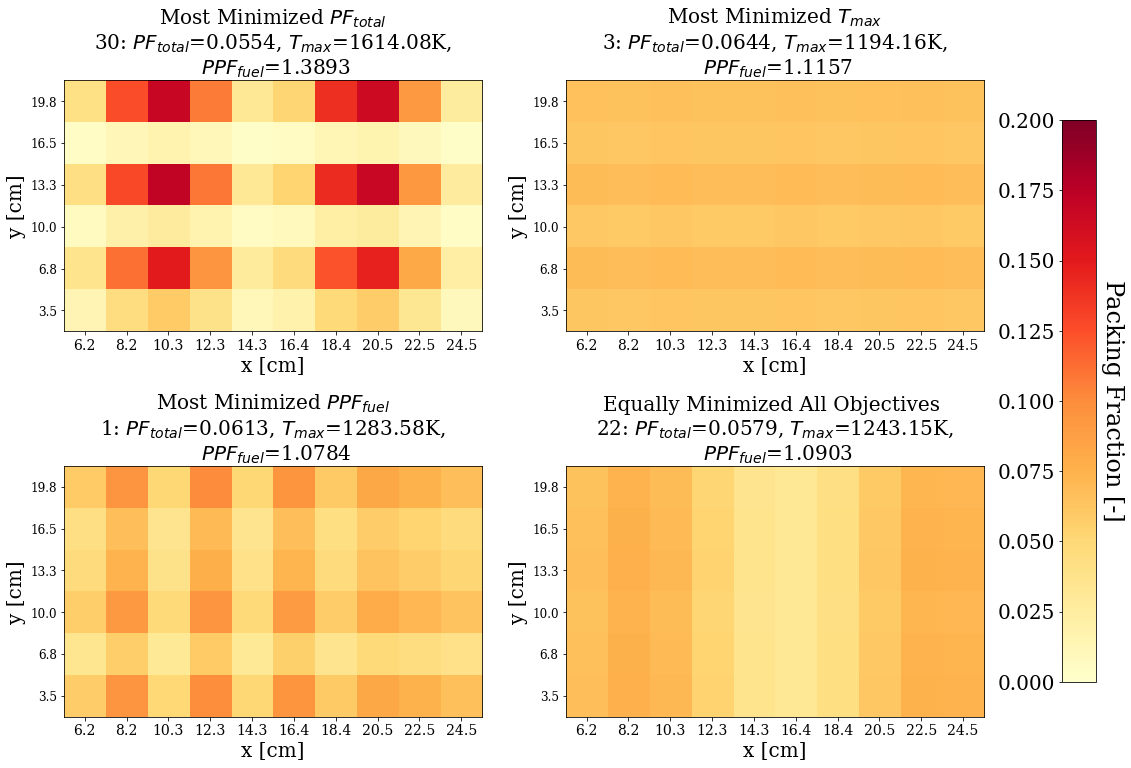

In [20]:
results = cp["all"]
pop = results["populations"][4]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
equally_min = 22-1
print("PF, TEMP, PPF", pf_min+1, temp_min+1, ppf_min+1)
fig, axes = plt.subplots(figsize=(12,13), nrows=2, ncols=2)
num = 1
count = 0
for i in [pf_min, temp_min, ppf_min, equally_min]:
    #if i in [pf_min, temp_min, ppf_min]:
    ind = non_dom[i]
    print("gen, num", ind.gen, ind.num)
    print(ind)
    #print("PPF", obj_2[i])
    #print(i, ind)
    #print("fitness", ind.fitness)
    ax = axes.flat[count]
    count += 1
    pf_distr = calc_pf_distr(ind, True)
    print(i, "STD", np.std(pf_distr))
    #for row in pf_distr:
        #print(np.max(row)- np.min(row))
    #    print(np.max(row))
    for j in range(10):
        col = pf_distr[:, j]
         #print(np.max(col)-np.min(col))
        print(np.mean(col))
    im = ax.imshow(pf_distr, vmin=0.00, vmax=0.2,cmap="YlOrRd")
    if i == pf_min:
        title_start = "Most Minimized $PF_{total}$ \n"
    if i == temp_min:
        title_start = "Most Minimized $T_{max}$ \n"
    if i == ppf_min:
        title_start = "Most Minimized $PPF_{fuel}$ \n"
    if i == equally_min:
        title_start = "Equally Minimized All Objectives \n"
    ax.set_title(title_start + str(i+1)+": $PF_{total}$="+str(round(ind.output[0],4)) + ", $T_{max}$="+str(round(ind.output[1],2))+
                 "K,\n $PPF_{fuel}$="+str(round(ind.output[2],4)), fontsize=20)
    ax.set_xlabel("x [cm]", fontsize=20)
    ax.set_ylabel("y [cm]", fontsize=20)
    ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
    ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=12)
    num += 1
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.28, 0.2, 0.04, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=20)
cb.set_label("Packing Fraction [-]", fontsize=24, rotation=270, labelpad=28)
#ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
plt.savefig("assem-obj-3-distr-most-minimized.png",bbox_inches='tight', dpi=300)


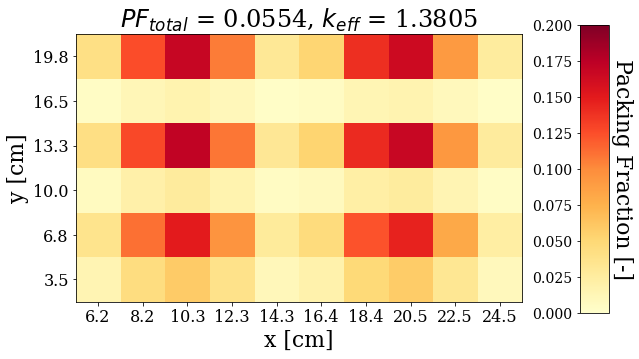

In [21]:
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
pf_most_minimized = final_non_dom[29]
pf_distr = calc_pf_distr(pf_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(pf_most_minimized.output[0],4))
             + ", $k_{eff}$ = "+str(round(pf_most_minimized.output[3],4)), 
                 fontsize=24)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
ax.tick_params(axis='both', which='major', labelsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3a-pf-most-minimized.png",bbox_inches='tight', dpi=300)


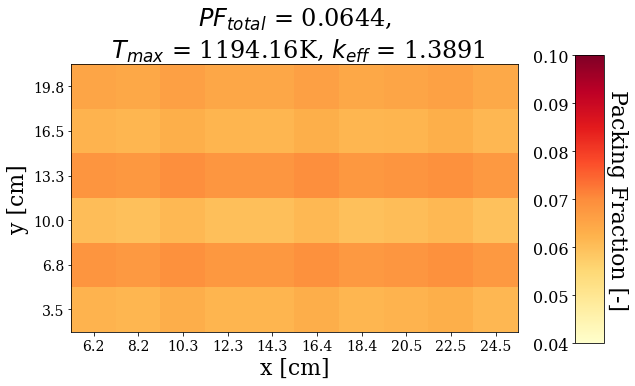

In [22]:
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
temp_most_minimized = final_non_dom[2]
pf_distr = calc_pf_distr(temp_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(temp_most_minimized.output[0],4)) 
             + ",\n $T_{max}$ = "+str(round(temp_most_minimized.output[1],2))
             + "K, $k_{eff}$ = "+str(round(temp_most_minimized.output[3],4)), 
                 fontsize=24)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=16) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3a-temp-most-minimized.png",bbox_inches='tight', dpi=300)


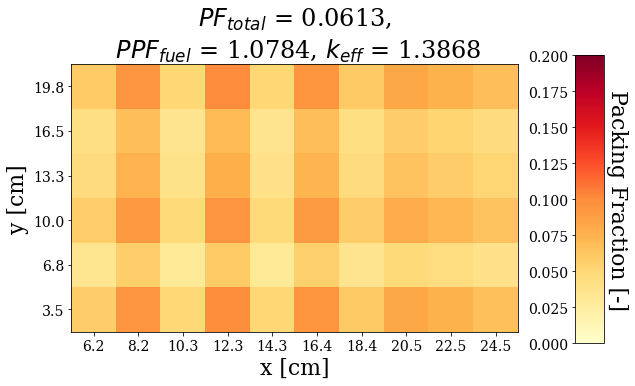

In [23]:
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
ppf_most_minimized = final_non_dom[0]
pf_distr = calc_pf_distr(ppf_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(ppf_most_minimized.output[0],4)) 
             + ",\n $PPF_{fuel}$ = "+str(round(ppf_most_minimized.output[2],4))
             + ", $k_{eff}$ = "+str(round(ppf_most_minimized.output[3],4)), 
                 fontsize=24)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3a-ppf-most-minimized.png",bbox_inches='tight', dpi=300)


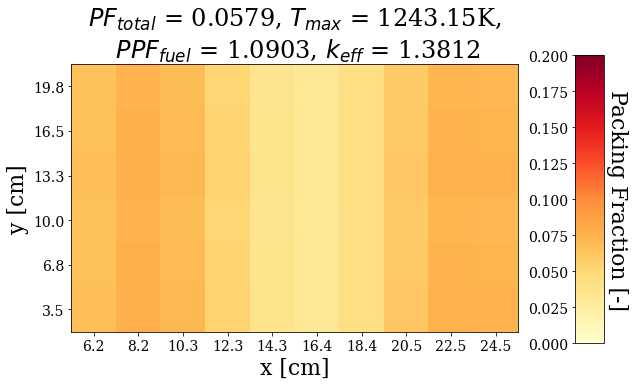

In [24]:
final_pop = results["populations"][4]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
all_most_minimized = final_non_dom[21]
pf_distr = calc_pf_distr(all_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(all_most_minimized.output[0],4)) 
             + ", $T_{max}$ = "+str(round(all_most_minimized.output[1],2))
             + "K,\n $PPF_{fuel}$ = "+str(round(all_most_minimized.output[2],4))
             + ", $k_{eff}$ = "+str(round(all_most_minimized.output[3],4)), 
                 fontsize=24)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3a-all-most-minimized.png",bbox_inches='tight', dpi=300)
